In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

In [38]:
chess_board_distorted=[]
for i in range (20):
    image=mpimg.imread('camera_cal/calibration'+str(i+1)+'.jpg')
    chess_board_distorted.append(image)


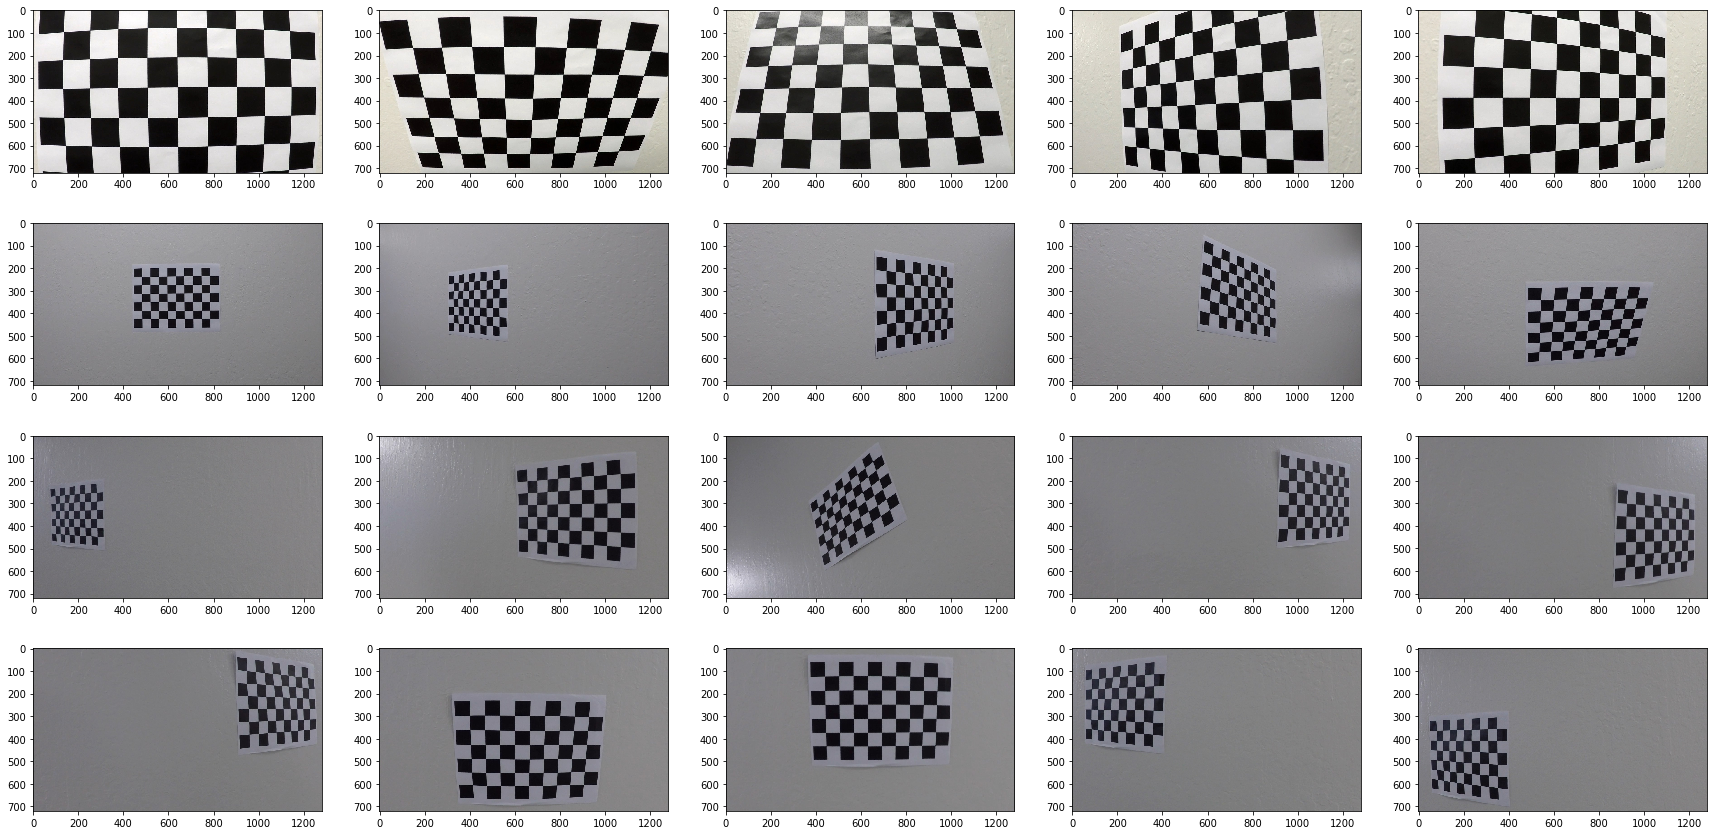

In [39]:
f = plt.figure(figsize=(30,15))
num=1
for image in chess_board_distorted:
    plt.subplot(4,5,num)
    plt.imshow(image)
    num=num+1

In [40]:
obj_points = []
image_points = []
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
for img in chess_board_distorted:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret==True:
        image_points.append(corners)
        obj_points.append(objp)

        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, gray.shape[::-1], None, None)        

In [41]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [42]:
def load_images_from_folder(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory,filename))
        if img is not None:
            images.append(img)
    return images

In [43]:
test_images_distorted=load_images_from_folder("test_images/")

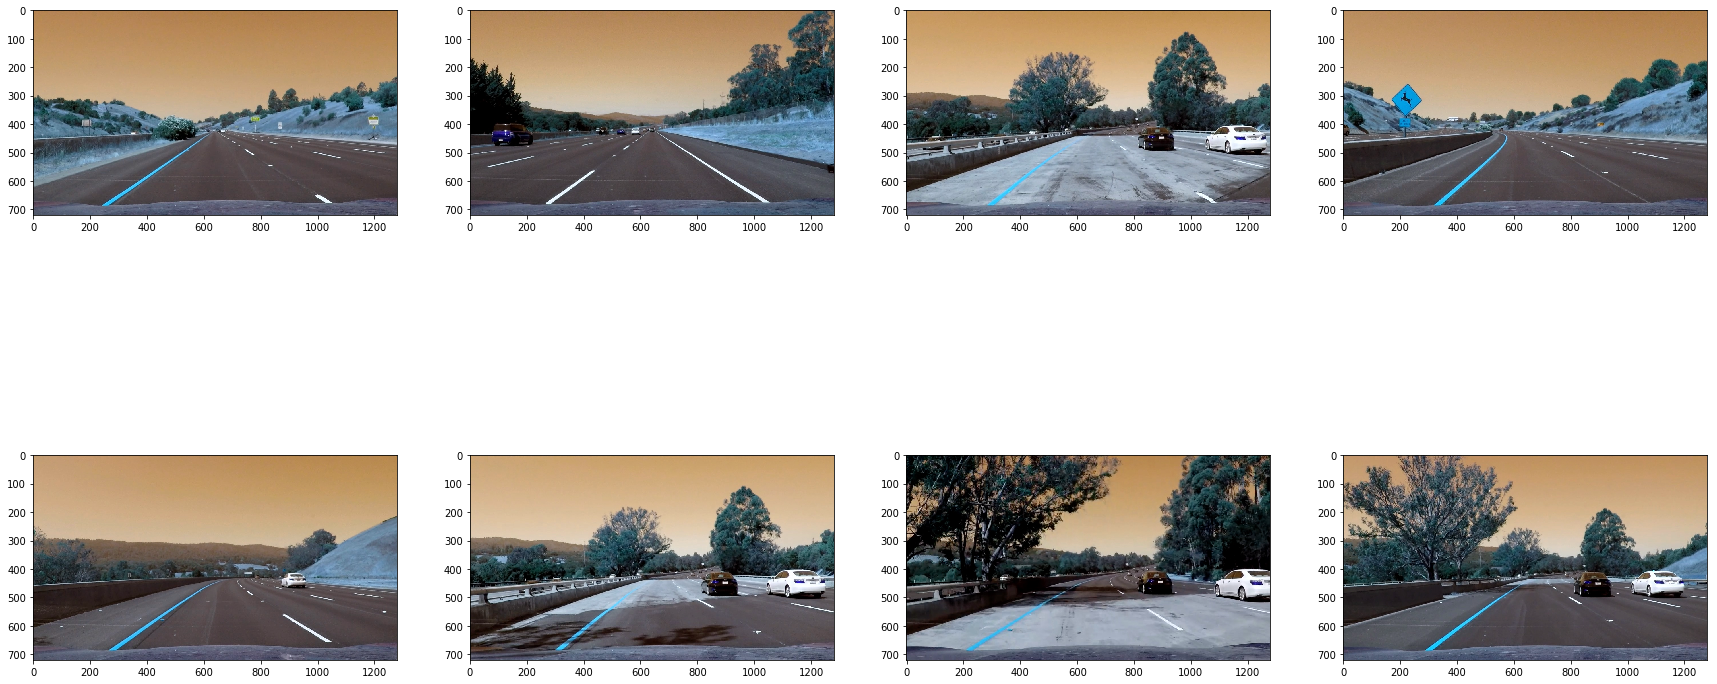

In [44]:
f = plt.figure(figsize=(30,15))
num=1
for image in test_images_distorted:
    plt.subplot(2,4,num)
    plt.imshow(image)
    num=num+1

In [45]:
test_images=[]
for img in test_images_distorted:
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    test_images.append(undist_img)

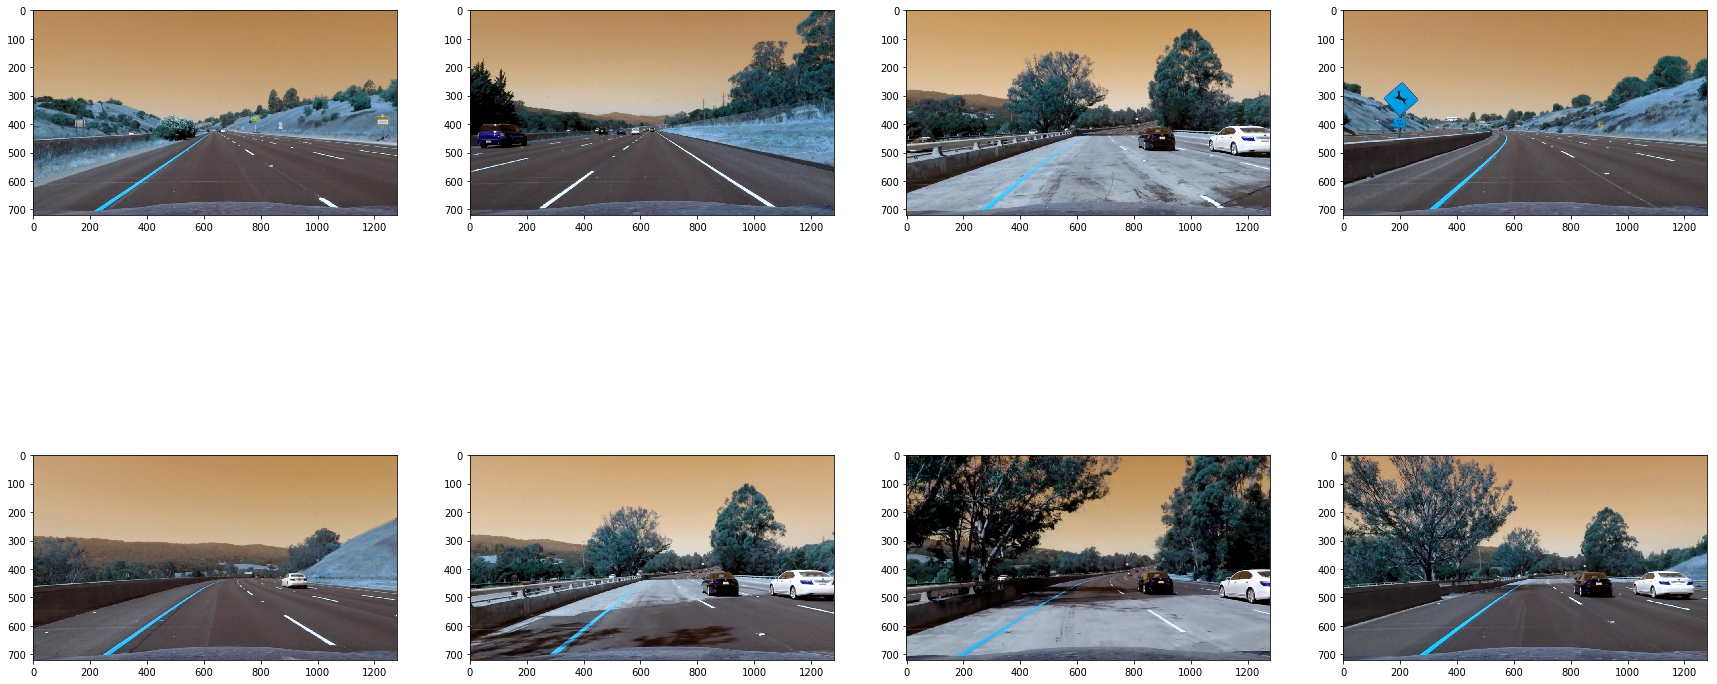

In [46]:
f = plt.figure(figsize=(30,15))
num=1
for image in test_images:
    plt.subplot(2,4,num)
    plt.imshow(image)
    num=num+1

In [47]:
color_gradient_images=[]
for img in test_images:
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    color_gradient_images.append(combined_binary)

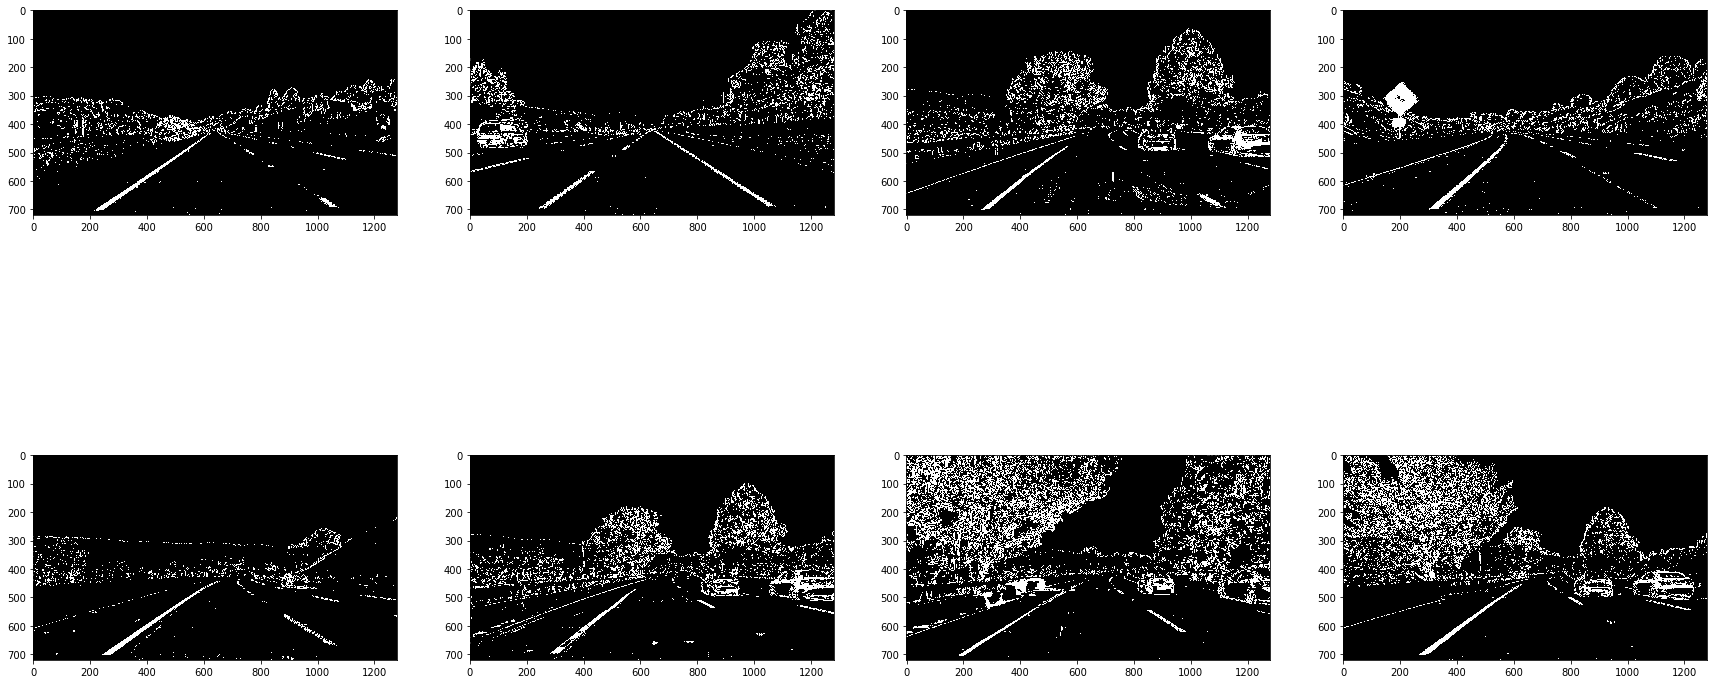

In [48]:
f = plt.figure(figsize=(30,15))
num=1
for image in color_gradient_images:
    plt.subplot(2,4,num)
    plt.imshow(image ,cmap='gray')
    num=num+1

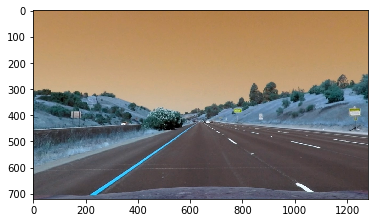

In [49]:
plt.imshow(test_images[0])

In [50]:
src = np.float32([[585,450], [200,710],[1130,720],[710,460]])
dst = np.float32([[145,0],[145,720],[test_images[0].shape[1]-145,720],[test_images[0].shape[1]-145,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [51]:
wraped_images=[]
for img in color_gradient_images:
    wrap_img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    wraped_images.append(wrap_img)

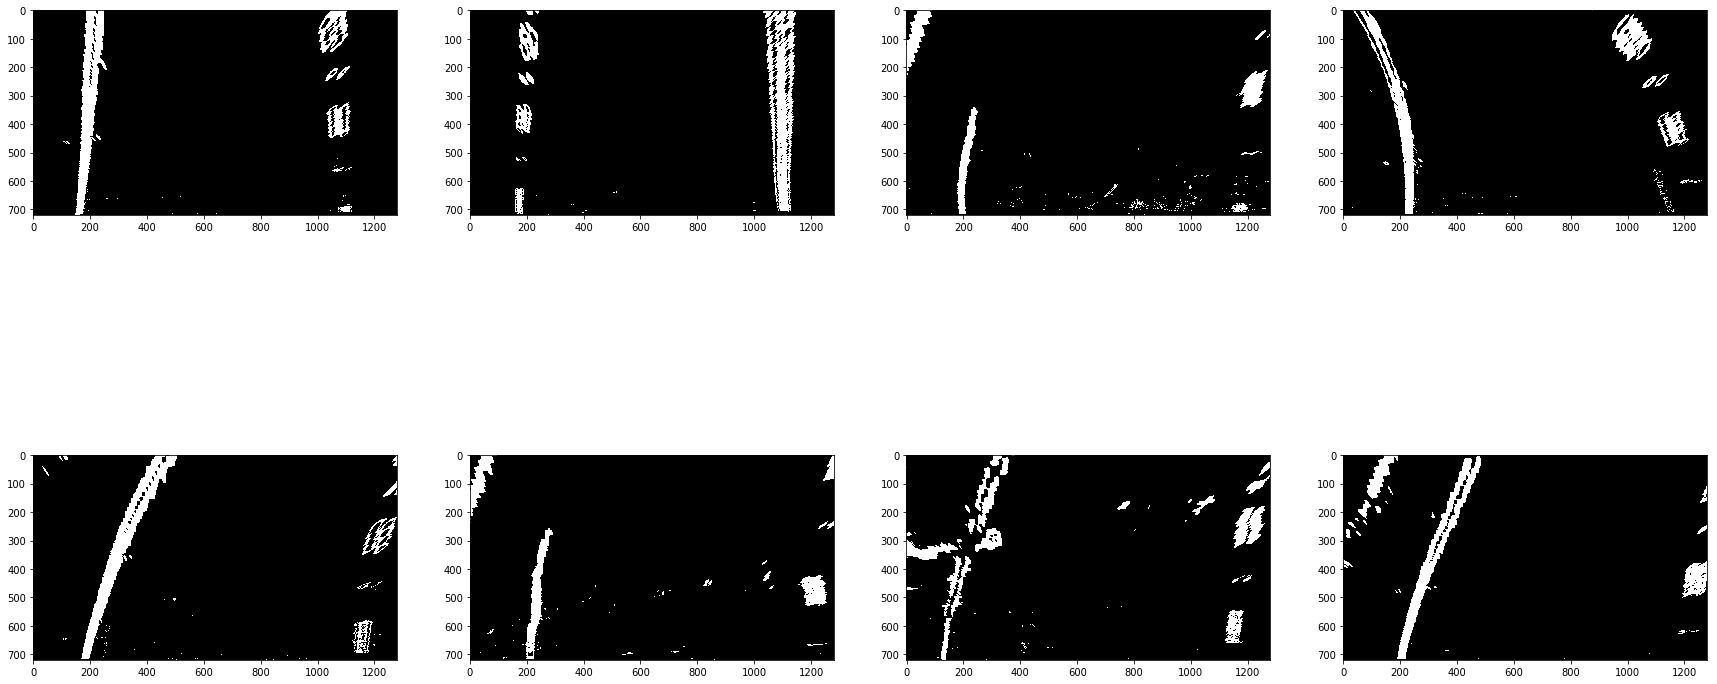

In [52]:
f = plt.figure(figsize=(30,15))
num=1
for image in wraped_images:
    plt.subplot(2,4,num)
    plt.imshow(image ,cmap='gray')
    num=num+1

In [53]:
def measure_curvature_real(leftx,rightx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    new_ploty=y_eval*ym_per_pix
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    distance=((left_fit_cr[0]*new_ploty**2 + left_fit_cr[1]*new_ploty + left_fit_cr[2])+(right_fit_cr[0]*new_ploty**2 + right_fit_cr[1]*new_ploty + right_fit_cr[2]))/2
    
    return left_curverad, right_curverad,distance

In [54]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [55]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_curverad, right_curverad,distance = measure_curvature_real(left_fitx,right_fitx,ploty)
    

    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    return color_warp, left_curverad, right_curverad ,distance


In [56]:
color_warp_imgs=[]
left_curverad_list=[]
right_curverad_list=[]
distances=[]
for image in wraped_images:
    color_warp, left_curverad, right_curverad, distance=fit_polynomial(image)  
    color_warp_imgs.append(color_warp)
    left_curverad_list.append(left_curverad)
    right_curverad_list.append(right_curverad)
    distances.append(distance)

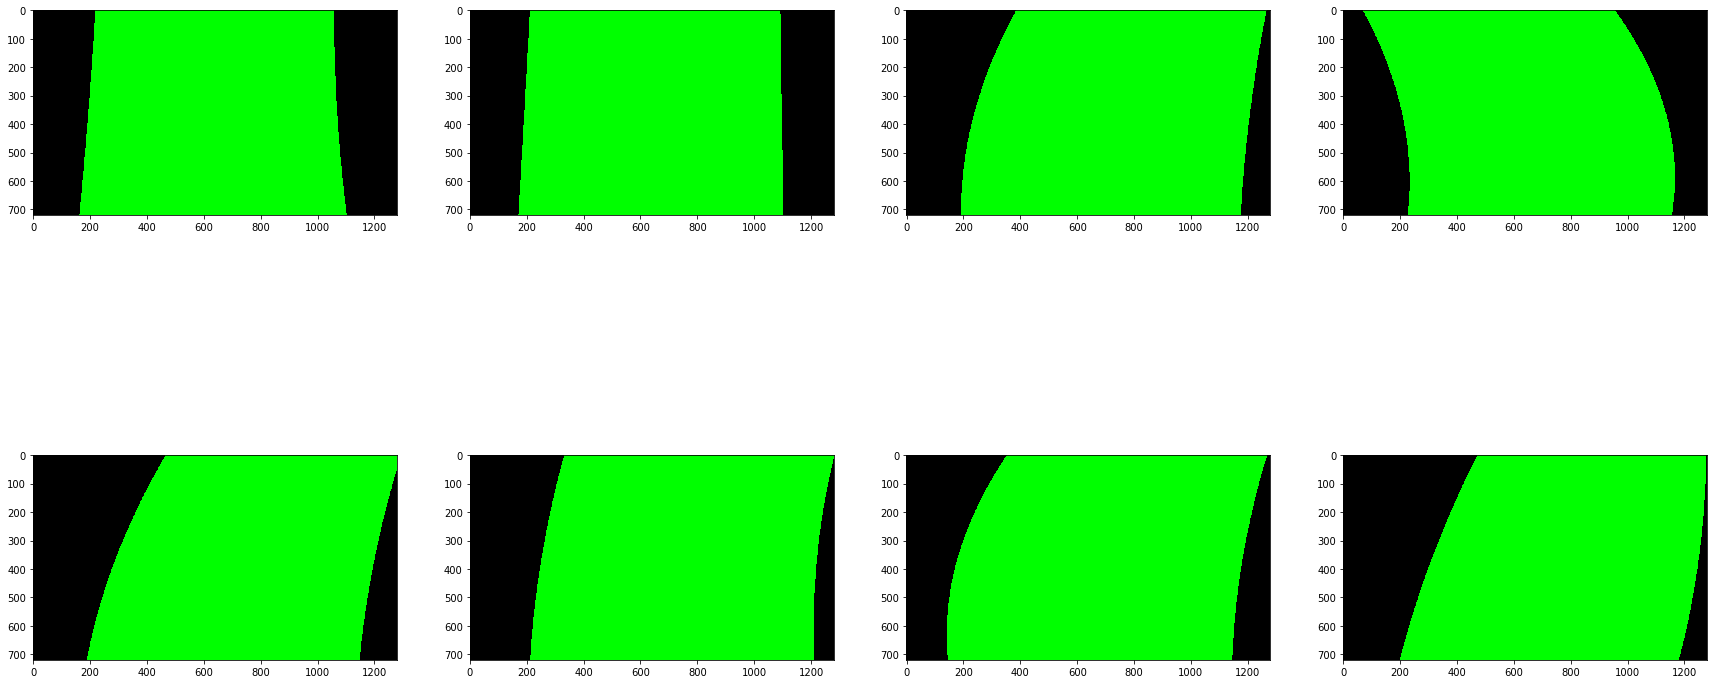

In [57]:
f = plt.figure(figsize=(30,15))
num=1
for image in color_warp_imgs:
    plt.subplot(2,4,num)
    plt.imshow(image ,cmap='gray')
    num=num+1

In [58]:
newwarp_imgs=[]
for image in color_warp_imgs:
    newwarp = cv2.warpPerspective(image, Minv, (image.shape[1], image.shape[0])) 
    newwarp_imgs.append(newwarp)

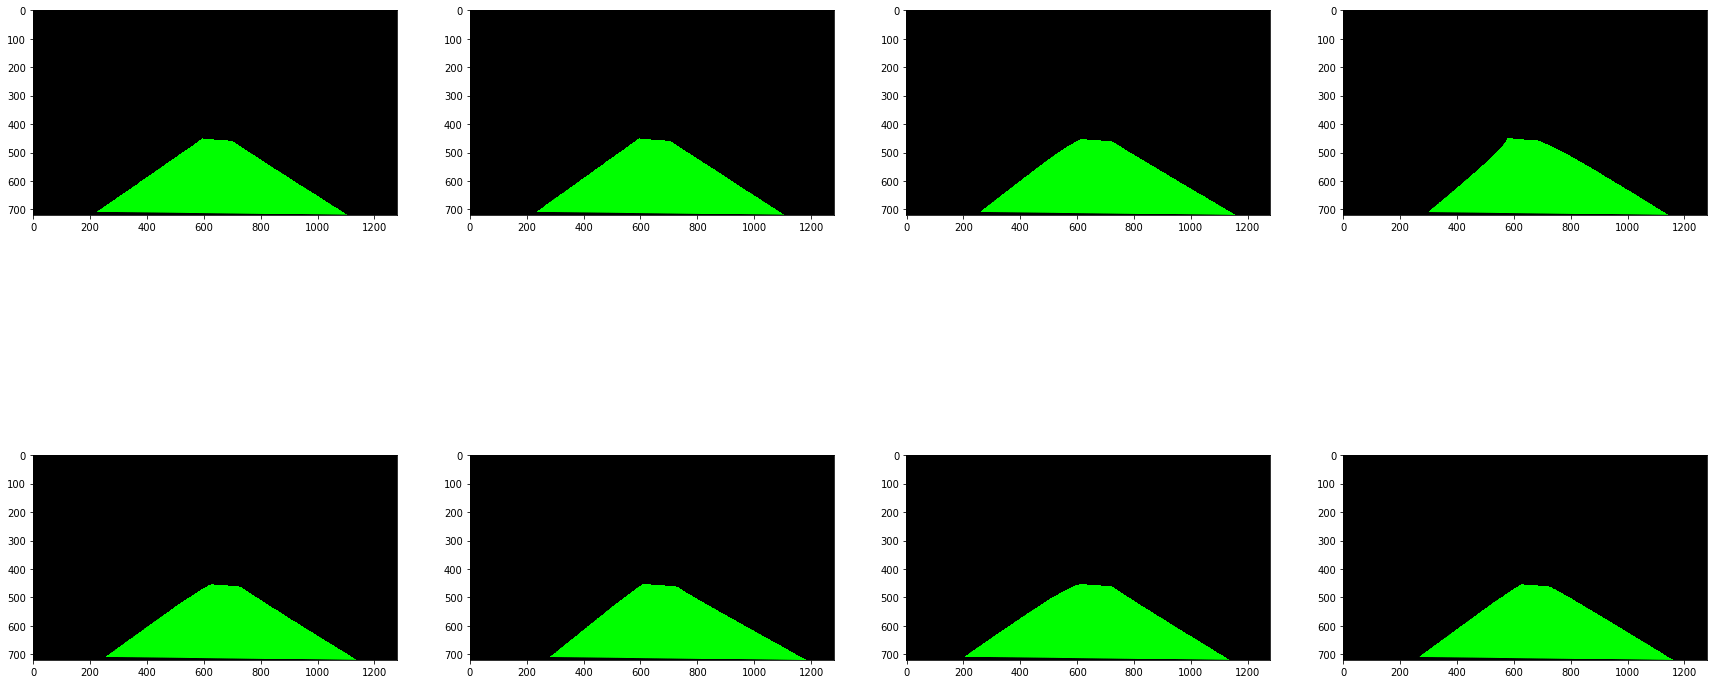

In [59]:
f = plt.figure(figsize=(30,15))
num=1
for image in newwarp_imgs:
    plt.subplot(2,4,num)
    plt.imshow(image ,cmap='gray')
    num=num+1

In [60]:
w_imgs=[]
for item1,item2 in zip(test_images,newwarp_imgs):
    w_img = cv2.addWeighted(item1, 1, item2, 0.3, 0)
    w_imgs.append(w_img)

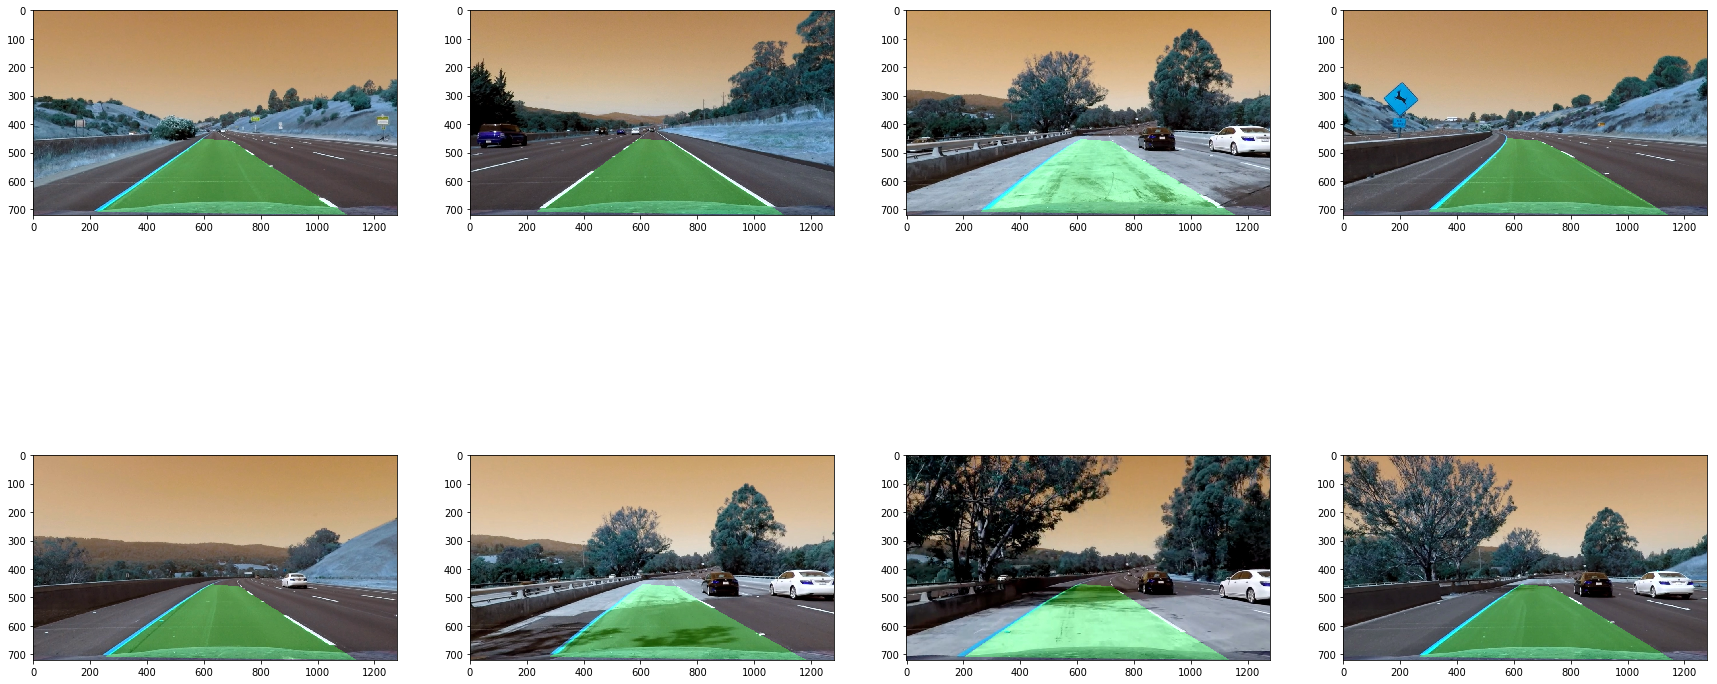

In [61]:
f = plt.figure(figsize=(30,15))
num=1
for image in w_imgs:
    plt.subplot(2,4,num)
    plt.imshow(image ,cmap='gray')
    num=num+1

In [62]:
for item1 in left_curverad_list:
    print(item1)

6521.366774069493
56326.99232880985
420.3778634171677
360.09659450165816
598.6806997929925
1097.9953571689514
310.61361533646334
957.5309265182801


In [63]:
for item1 in right_curverad_list:
    print(item1)

1858.1673758523011
71503.47501482205
1645.7782919382053
269.5160909931786
1082.0040355617473
821.2692957468131
867.0078686785826
931.3822236437951


In [64]:
#for item in distances:
#    print(distance)

In [65]:
font = cv2.FONT_HERSHEY_TRIPLEX
for i in range(8):
    cv2.putText(w_imgs[i],'Radius Of Curvature is : '+str(int((left_curverad_list[i]+right_curverad_list[i])/2))+' (m)',(10,100), font, 2, (255,255,255), 8, cv2.LINE_AA)
    #dist=distances[i]-test_images[0].shape[1]*3.7/700
    #dist_f="%.2f" % dist
    #cv2.putText(w_imgs[i],'distance from left of the centre is : '+str(dist_f)+' (m)',(10,200), font, 1.5, (255,255,255), 8, cv2.LINE_AA)

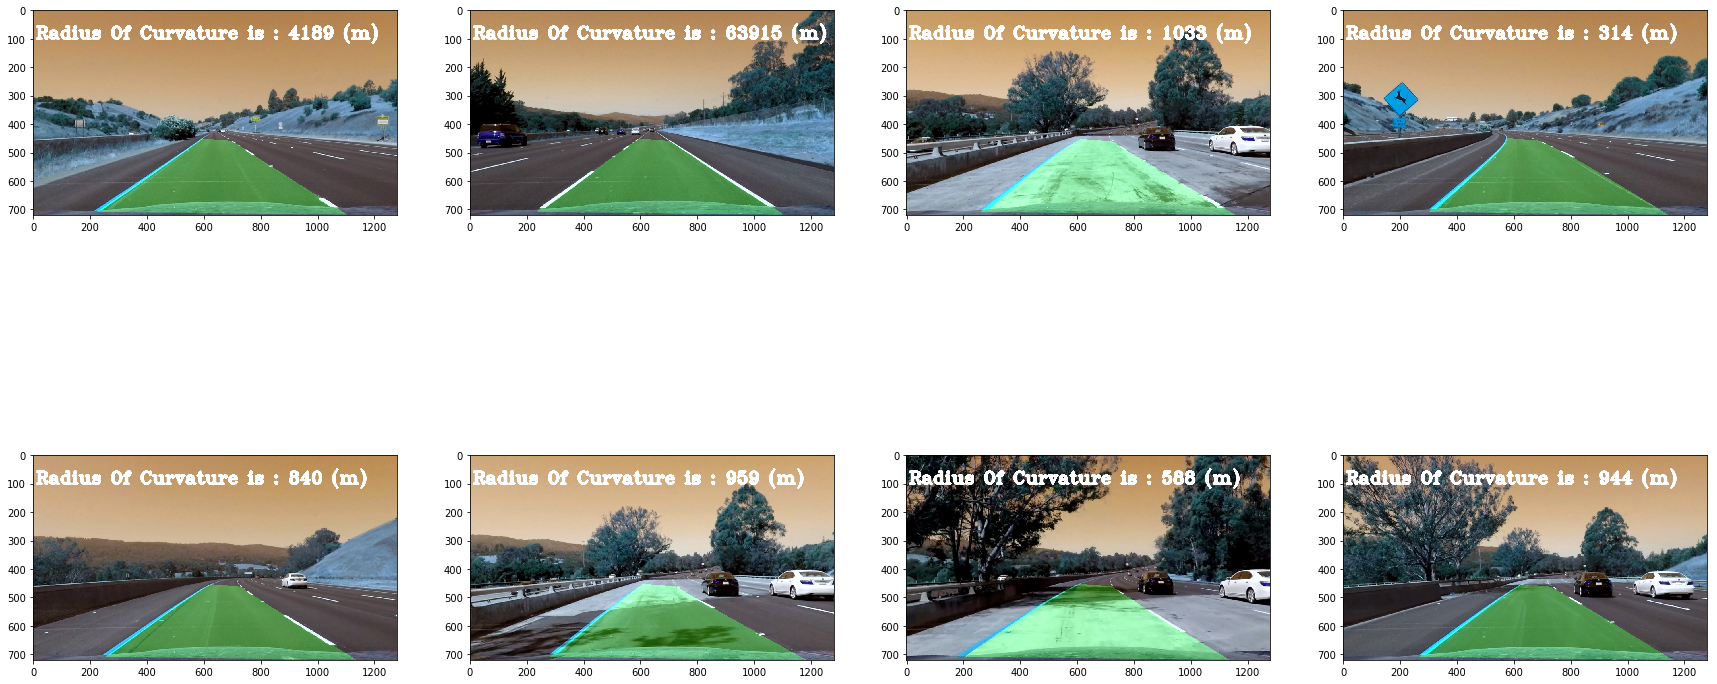

In [66]:
f = plt.figure(figsize=(30,15))
num=1
for image in w_imgs:
    plt.subplot(2,4,num)
    plt.imshow(image ,cmap='gray')
    num=num+1

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [76]:
def process_image(img):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    iamge = np.copy(undist_img)
    hls = cv2.cvtColor(iamge, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(iamge, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    wrap_img = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]))
    
    color_warp, left_curverad, right_curverad, distance=fit_polynomial(wrap_img)
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0]))
    
    w_img = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_TRIPLEX
    
    cv2.putText(w_img,'Radius Of Curvature is : '+str(int((left_curverad+right_curverad)/2))+' (m) ',(10,100), font, 2, (255,255,255), 8, cv2.LINE_AA)
    half=(undist_img.shape[1]/2)*(3.7/700)
    cv2.putText(w_img,str(round((distance-half),2)) +' (m) left from the centre',(20,200), font, 1.5, (255,255,255), 5, cv2.LINE_AA)
    return w_img

In [77]:
white_output = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid